In [1]:
import torch
from torch import nn
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchvision import transforms
from pathlib import Path

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
import zipfile

# Extract the archive
zip_ref = zipfile.ZipFile("/content/drive/MyDrive/Dataset/dataset.zip", 'r')
zip_ref.extractall("dataset/")
zip_ref.close()

In [4]:
data_paths = Path('/content/dataset')
train_dir= data_paths / '/content/dataset/Training'
test_dir = data_paths / '/content/dataset/Testing'
#valid_dir = data_paths / '/content/tmp/data_split/validation'
#valid_dir = data_paths / 'validation'
#test_dir = data_paths / 'test'
BATCH_SIZE = 32

In [5]:
IMG_SIZE = 224
BATCH_SIZE = 32
def create_dataloaders(
    train_dir: str,
    test_dir: str,
    transform: transforms.Compose,
    batch_size: int):

    train_data = datasets.ImageFolder(train_dir, transform=transform)
    test_data = datasets.ImageFolder(test_dir, transform=transform)

    class_names = train_data.classes

    train_dataloader = DataLoader(
      train_data,
      batch_size=batch_size,
      shuffle=True,
      pin_memory=True,
    )
    test_dataloader = DataLoader(
      test_data,
      batch_size=batch_size,
      shuffle=False,
      pin_memory=True,
    )

    return train_dataloader, test_dataloader, class_names

In [6]:
transforms_train = transforms.Compose(
    [
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.RandomHorizontalFlip(p=0.3),
        transforms.RandomResizedCrop(IMG_SIZE),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    ]
)

transforms_test = transforms.Compose(
    [
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    ]
)

In [7]:
train_dataloader, _, _ = create_dataloaders(train_dir=train_dir, test_dir= test_dir, batch_size=BATCH_SIZE,transform = transforms_train)
_, test_dataloader, _ = create_dataloaders(train_dir=train_dir, test_dir= test_dir, batch_size=BATCH_SIZE,transform = transforms_test)
#_, valid_dataloader, classnames = create_dataloaders(train_dir=train_dir, test_dir= valid_dir, batch_size=BATCH_SIZE,transform = transforms_test)

In [8]:
img, label = next(iter(train_dataloader))
img, label = img[0], label[0]

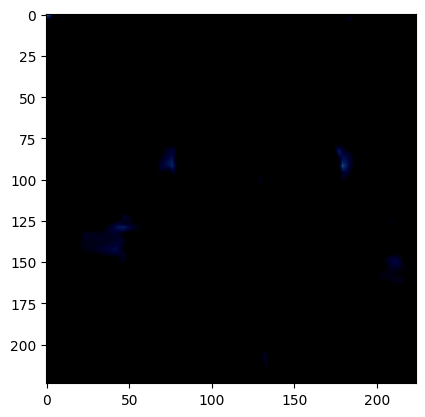

In [9]:
import matplotlib.pyplot as plt
plt.imshow(img.permute(1,2,0))

In [26]:
EPOCHS = 25

In [11]:
# this code is from github repe that I take from

from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
from tqdm.auto import tqdm
from typing import Dict, List, Tuple
import seaborn as sns
def train_step(model: torch.nn.Module,
               dataloader: DataLoader,
               loss_fn: nn.Module,
               optimizer: torch.optim.Optimizer,
               device: torch.device) -> Dict[str, float]:

    model.train()
    train_loss, train_acc = 0, 0
    all_labels, all_preds = [], []

    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        y_pred = model(X)
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

        all_labels.extend(y.cpu().numpy())
        all_preds.extend(y_pred_class.cpu().numpy())

    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)

    train_precision = precision_score(all_labels, all_preds, average='weighted')
    train_recall = recall_score(all_labels, all_preds, average='weighted')
    train_f1 = f1_score(all_labels, all_preds, average='weighted')

    return {
        "loss": train_loss,
        "accuracy": train_acc,
        "precision": train_precision,
        "recall": train_recall,
        "f1": train_f1
    }

def test_step(model: torch.nn.Module,
              dataloader: DataLoader,
              loss_fn: nn.Module,
              device: torch.device) -> Tuple[Dict[str, float], List[int], List[int]]:

    model.eval()
    test_loss, test_acc = 0, 0
    all_labels, all_preds = [], []

    with torch.inference_mode():
        for batch, (X, y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)
            test_pred_logits = model(X)

            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

            all_labels.extend(y.cpu().numpy())
            all_preds.extend(test_pred_labels.cpu().numpy())

    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)

    test_precision = precision_score(all_labels, all_preds, average='weighted')
    test_recall = recall_score(all_labels, all_preds, average='weighted')
    test_f1 = f1_score(all_labels, all_preds, average='weighted')

    return {
        "loss": test_loss,
        "accuracy": test_acc,
        "precision": test_precision,
        "recall": test_recall,
        "f1": test_f1
    }, all_labels, all_preds

def train(model: torch.nn.Module,
          train_dataloader: DataLoader,
          test_dataloader: DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: nn.Module,
          epochs: int,
          device: torch.device) -> Dict[str, List]:

    results = {
        "train_loss": [],
        "train_acc": [],
        "train_precision": [],
        "train_recall": [],
        "train_f1": [],
        "test_loss": [],
        "test_acc": [],
        "test_precision": [],
        "test_recall": [],
        "test_f1": []
    }

    model.to(device)

    final_all_labels = []
    final_all_preds = []

    for epoch in tqdm(range(epochs)):
        train_metrics = train_step(model=model,
                                   dataloader=train_dataloader,
                                   loss_fn=loss_fn,
                                   optimizer=optimizer,
                                   device=device)
        test_metrics, all_labels, all_preds = test_step(model=model,
                                 dataloader=test_dataloader,
                                 loss_fn=loss_fn,
                                 device=device)

        if epoch == epochs - 1:
            final_all_labels = all_labels
            final_all_preds = all_preds

        print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_metrics['loss']:.4f} | "
          f"train_acc: {train_metrics['accuracy']:.4f} | "
          f"train_precision: {train_metrics['precision']:.4f} | "
          f"train_recall: {train_metrics['recall']:.4f} | "
          f"train_f1: {train_metrics['f1']:.4f} | "
          f"test_loss: {test_metrics['loss']:.4f} | "
          f"test_acc: {test_metrics['accuracy']:.4f} | "
          f"test_precision: {test_metrics['precision']:.4f} | "
          f"test_recall: {test_metrics['recall']:.4f} | "
          f"test_f1: {test_metrics['f1']:.4f}"
        )

        results["train_loss"].append(train_metrics['loss'])
        results["train_acc"].append(train_metrics['accuracy'])
        results["train_precision"].append(train_metrics['precision'])
        results["train_recall"].append(train_metrics['recall'])
        results["train_f1"].append(train_metrics['f1'])

        results["test_loss"].append(test_metrics['loss'])
        results["test_acc"].append(test_metrics['accuracy'])
        results["test_precision"].append(test_metrics['precision'])
        results["test_recall"].append(test_metrics['recall'])
        results["test_f1"].append(test_metrics['f1'])

    # Plot confusion matrix
    conf_matrix = confusion_matrix(final_all_labels, final_all_preds)
    plt.figure(figsize=(10, 7))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    return results

from pathlib import Path
def save_model(model: torch.nn.Module,
               target_dir: str,
               model_name: str):

    target_dir_path = Path(target_dir)
    target_dir_path.mkdir(parents=True,
                        exist_ok=True)

    assert model_name.endswith(".pth") or model_name.endswith(".pt"), "model_name should end with '.pt' or '.pth'"
    model_save_path = target_dir_path / model_name

    print(f"[INFO] Saving model to: {model_save_path}")
    torch.save(obj=model.state_dict(),
             f=model_save_path)

In [12]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
!pip install torchinfo
from torchinfo import summary

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
weights = torchvision.models.ViT_B_16_Weights.DEFAULT
model = torchvision.models.vit_b_16(weights=weights).to(device)

# Use torchinfo's summary instead
summary(model, input_size=(1, 3, 224, 224))

# Placeholder for training code
# results = train(model, train_dataloader, test_dataloader, optimizer=optimizer, loss_fn=loss_fn, epochs=EPOCHS, device=device)

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:01<00:00, 215MB/s]


Layer (type:depth-idx)                        Output Shape              Param #
VisionTransformer                             [1, 1000]                 768
├─Conv2d: 1-1                                 [1, 768, 14, 14]          590,592
├─Encoder: 1-2                                [1, 197, 768]             151,296
│    └─Dropout: 2-1                           [1, 197, 768]             --
│    └─Sequential: 2-2                        [1, 197, 768]             --
│    │    └─EncoderBlock: 3-1                 [1, 197, 768]             7,087,872
│    │    └─EncoderBlock: 3-2                 [1, 197, 768]             7,087,872
│    │    └─EncoderBlock: 3-3                 [1, 197, 768]             7,087,872
│    │    └─EncoderBlock: 3-4                 [1, 197, 768]             7,087,872
│    │    └─EncoderBlock: 3-5                 [1, 197, 768]             7,087,872
│    │    └─EncoderBlock: 3-6                 [1, 197, 768]             7,087,872
│    │    └─EncoderBlock: 3-7             

In [13]:
# Define loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9817 | train_acc: 0.5869 | train_precision: 0.5915 | train_recall: 0.5865 | train_f1: 0.5870 | test_loss: 1.0746 | test_acc: 0.5324 | test_precision: 0.6769 | test_recall: 0.5324 | test_f1: 0.4699
Epoch: 2 | train_loss: 0.9373 | train_acc: 0.6065 | train_precision: 0.6102 | train_recall: 0.6070 | train_f1: 0.6064 | test_loss: 1.0005 | test_acc: 0.5445 | test_precision: 0.6319 | test_recall: 0.5446 | test_f1: 0.5430
Epoch: 3 | train_loss: 0.8802 | train_acc: 0.6341 | train_precision: 0.6363 | train_recall: 0.6341 | train_f1: 0.6332 | test_loss: 0.9969 | test_acc: 0.5515 | test_precision: 0.6164 | test_recall: 0.5515 | test_f1: 0.5487
Epoch: 4 | train_loss: 0.8463 | train_acc: 0.6407 | train_precision: 0.6429 | train_recall: 0.6409 | train_f1: 0.6404 | test_loss: 0.9872 | test_acc: 0.5414 | test_precision: 0.6147 | test_recall: 0.5416 | test_f1: 0.5216
Epoch: 5 | train_loss: 0.8152 | train_acc: 0.6629 | train_precision: 0.6653 | train_recall: 0.6625 | train_f1: 0

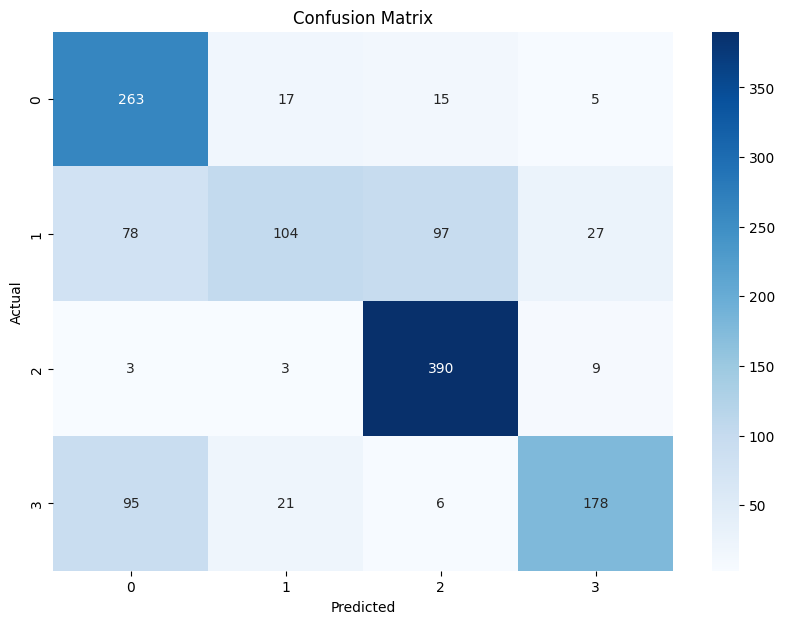

In [15]:
results = train(model, train_dataloader, test_dataloader, optimizer = optimizer, loss_fn=loss_fn, epochs=EPOCHS, device=device)

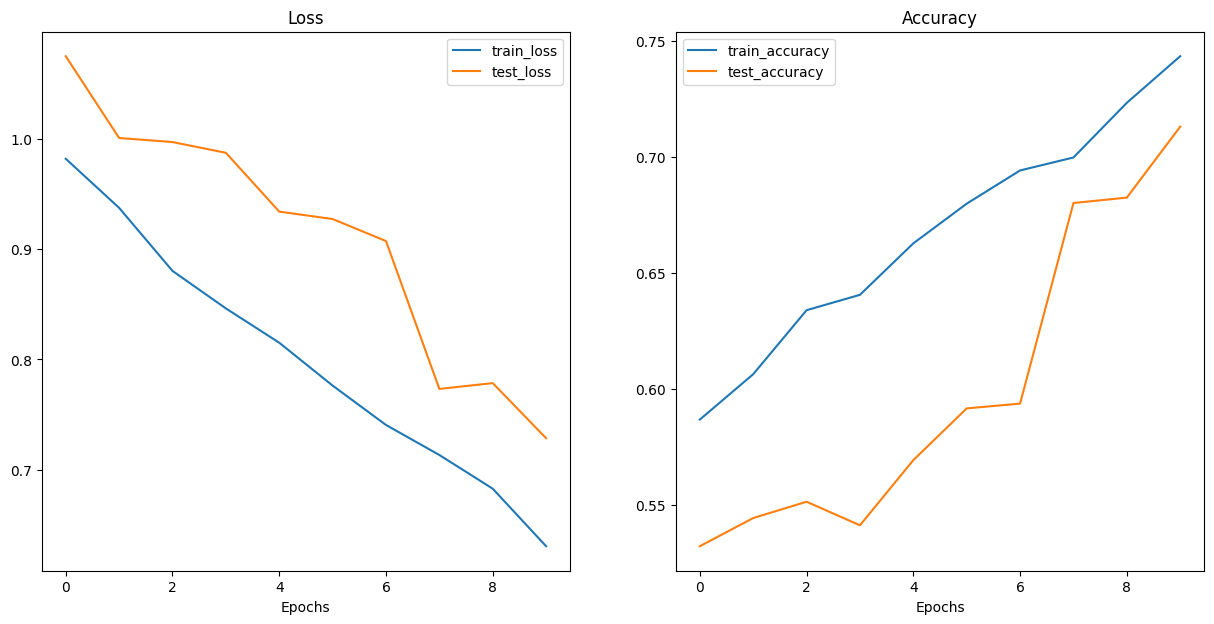

In [16]:
loss = results["train_loss"]
test_loss = results["test_loss"]

accuracy = results["train_acc"]
test_accuracy = results["test_acc"]

epochs = range(len(results["train_loss"]))

plt.figure(figsize=(15, 7))

plt.subplot(1, 2, 1)
plt.plot(epochs, loss, label="train_loss")
plt.plot(epochs, test_loss, label="test_loss")
plt.title("Loss")
plt.xlabel("Epochs")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, accuracy, label="train_accuracy")
plt.plot(epochs, test_accuracy, label="test_accuracy")
plt.title("Accuracy")
plt.xlabel("Epochs")
plt.legend()

In [18]:
save_model(model=model,
                 target_dir="models",
                 model_name="vit-10-Epochs-TP-model.pth")

[INFO] Saving model to: models/vit-10-Epochs-TP-model.pth


@@@@@@

In [19]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load the model with default weights
weights = torchvision.models.ViT_B_16_Weights.DEFAULT
model2 = torchvision.models.vit_b_16(weights=weights).to(device)

# Modify the classifier head
num_classes = 4
num_features = model2.heads[0].in_features  # Accessing the Linear layer's in_features
model2.heads = nn.Linear(num_features, num_classes).to(device)

# Freeze all layers
for param in model2.parameters():
    param.requires_grad = False

# Unfreeze the classifier head to train it
for param in model2.heads.parameters():
    param.requires_grad = True

# Print the model architecture
summary(model2, input_size=(1, 3, 224, 224))

Layer (type:depth-idx)                        Output Shape              Param #
VisionTransformer                             [1, 4]                    768
├─Conv2d: 1-1                                 [1, 768, 14, 14]          (590,592)
├─Encoder: 1-2                                [1, 197, 768]             151,296
│    └─Dropout: 2-1                           [1, 197, 768]             --
│    └─Sequential: 2-2                        [1, 197, 768]             --
│    │    └─EncoderBlock: 3-1                 [1, 197, 768]             (7,087,872)
│    │    └─EncoderBlock: 3-2                 [1, 197, 768]             (7,087,872)
│    │    └─EncoderBlock: 3-3                 [1, 197, 768]             (7,087,872)
│    │    └─EncoderBlock: 3-4                 [1, 197, 768]             (7,087,872)
│    │    └─EncoderBlock: 3-5                 [1, 197, 768]             (7,087,872)
│    │    └─EncoderBlock: 3-6                 [1, 197, 768]             (7,087,872)
│    │    └─EncoderBlock: 3-

In [20]:
# Define loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model2.parameters(), lr=0.001)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.5878 | train_acc: 0.7893 | train_precision: 0.7897 | train_recall: 0.7894 | train_f1: 0.7884 | test_loss: 0.4597 | test_acc: 0.8376 | test_precision: 0.8372 | test_recall: 0.8375 | test_f1: 0.8359
Epoch: 2 | train_loss: 0.3868 | train_acc: 0.8572 | train_precision: 0.8579 | train_recall: 0.8575 | train_f1: 0.8573 | test_loss: 0.3844 | test_acc: 0.8742 | test_precision: 0.8734 | test_recall: 0.8741 | test_f1: 0.8721
Epoch: 3 | train_loss: 0.3337 | train_acc: 0.8818 | train_precision: 0.8823 | train_recall: 0.8817 | train_f1: 0.8816 | test_loss: 0.3465 | test_acc: 0.8681 | test_precision: 0.8715 | test_recall: 0.8680 | test_f1: 0.8687
Epoch: 4 | train_loss: 0.3110 | train_acc: 0.8870 | train_precision: 0.8877 | train_recall: 0.8871 | train_f1: 0.8873 | test_loss: 0.3315 | test_acc: 0.8864 | test_precision: 0.8852 | test_recall: 0.8863 | test_f1: 0.8851
Epoch: 5 | train_loss: 0.3020 | train_acc: 0.8898 | train_precision: 0.8897 | train_recall: 0.8895 | train_f1: 0

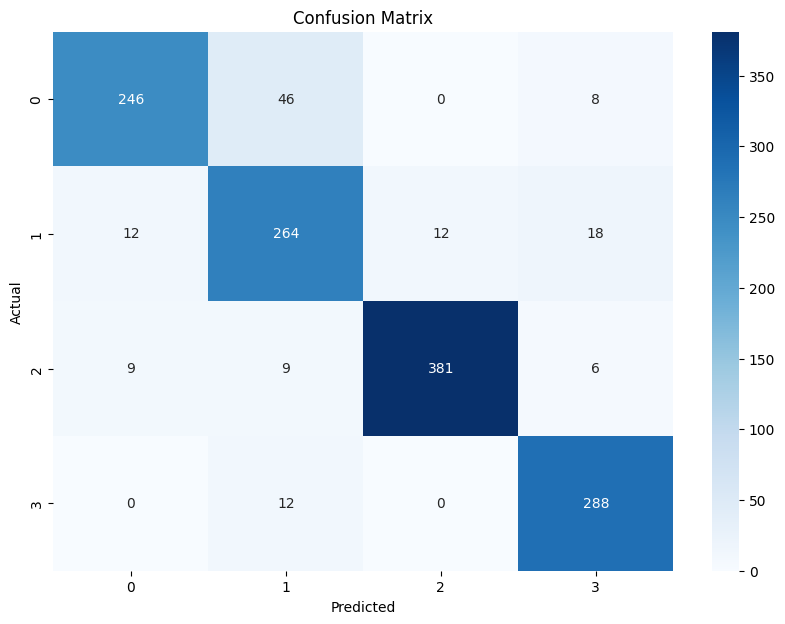

In [21]:
results = train(model2, train_dataloader, test_dataloader, optimizer = optimizer, loss_fn=loss_fn, epochs=EPOCHS, device=device)

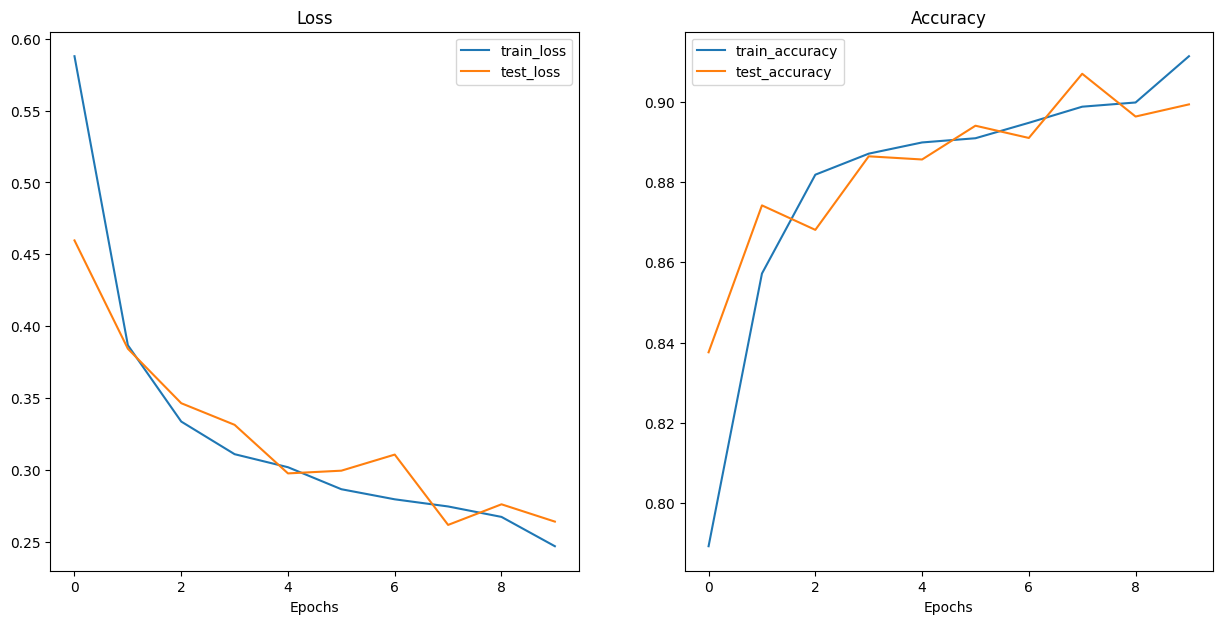

In [23]:
loss = results["train_loss"]
test_loss = results["test_loss"]

accuracy = results["train_acc"]
test_accuracy = results["test_acc"]

epochs = range(len(results["train_loss"]))

plt.figure(figsize=(15, 7))

plt.subplot(1, 2, 1)
plt.plot(epochs, loss, label="train_loss")
plt.plot(epochs, test_loss, label="test_loss")
plt.title("Loss")
plt.xlabel("Epochs")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, accuracy, label="train_accuracy")
plt.plot(epochs, test_accuracy, label="test_accuracy")
plt.title("Accuracy")
plt.xlabel("Epochs")
plt.legend()

In [24]:
save_model(model=model2,
                 target_dir="models",
                 model_name="vit-10-Epochs-NTP-model.pth")

[INFO] Saving model to: models/vit-10-Epochs-NTP-model.pth


In [25]:
class EarlyStopping:
    def __init__(self, patience=3, delta=0.001):
        """
        Args:
            patience (int): How many epochs to wait before stopping when validation loss is not improving.
            delta (float): Minimum change in the monitored metric to qualify as an improvement.
        """
        self.patience = patience
        self.delta = delta
        self.best_loss = None
        self.counter = 0
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

def train_with_early_stopping(model: torch.nn.Module,
                              train_dataloader: DataLoader,
                              test_dataloader: DataLoader,
                              optimizer: torch.optim.Optimizer,
                              loss_fn: nn.Module,
                              epochs: int,
                              patience: int,
                              device: torch.device) -> Dict[str, List]:

    # Instantiate early stopping
    early_stopping = EarlyStopping(patience=patience, delta=0.001)

    results = {
        "train_loss": [],
        "train_acc": [],
        "train_precision": [],
        "train_recall": [],
        "train_f1": [],
        "test_loss": [],
        "test_acc": [],
        "test_precision": [],
        "test_recall": [],
        "test_f1": []
    }

    model.to(device)

    final_all_labels = []
    final_all_preds = []

    for epoch in tqdm(range(epochs)):
        # Training step
        train_metrics = train_step(model=model,
                                   dataloader=train_dataloader,
                                   loss_fn=loss_fn,
                                   optimizer=optimizer,
                                   device=device)
        # Testing step
        test_metrics, all_labels, all_preds = test_step(model=model,
                                                        dataloader=test_dataloader,
                                                        loss_fn=loss_fn,
                                                        device=device)

        if epoch == epochs - 1:
            final_all_labels = all_labels
            final_all_preds = all_preds

        print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_metrics['loss']:.4f} | "
          f"train_acc: {train_metrics['accuracy']:.4f} | "
          f"train_precision: {train_metrics['precision']:.4f} | "
          f"train_recall: {train_metrics['recall']:.4f} | "
          f"train_f1: {train_metrics['f1']:.4f} | "
          f"test_loss: {test_metrics['loss']:.4f} | "
          f"test_acc: {test_metrics['accuracy']:.4f} | "
          f"test_precision: {test_metrics['precision']:.4f} | "
          f"test_recall: {test_metrics['recall']:.4f} | "
          f"test_f1: {test_metrics['f1']:.4f}"
        )

        # Update results
        results["train_loss"].append(train_metrics['loss'])
        results["train_acc"].append(train_metrics['accuracy'])
        results["train_precision"].append(train_metrics['precision'])
        results["train_recall"].append(train_metrics['recall'])
        results["train_f1"].append(train_metrics['f1'])

        results["test_loss"].append(test_metrics['loss'])
        results["test_acc"].append(test_metrics['accuracy'])
        results["test_precision"].append(test_metrics['precision'])
        results["test_recall"].append(test_metrics['recall'])
        results["test_f1"].append(test_metrics['f1'])

        # Check early stopping
        early_stopping(val_loss=test_metrics['loss'])
        if early_stopping.early_stop:
            print(f"[INFO] Early stopping at epoch {epoch+1}")
            break

    # Plot confusion matrix
    conf_matrix = confusion_matrix(final_all_labels, final_all_preds)
    plt.figure(figsize=(10, 7))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    return results


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.2176 | train_acc: 0.9193 | train_precision: 0.9192 | train_recall: 0.9191 | train_f1: 0.9191 | test_loss: 0.2298 | test_acc: 0.9146 | test_precision: 0.9174 | test_recall: 0.9146 | test_f1: 0.9143
Epoch: 2 | train_loss: 0.2163 | train_acc: 0.9218 | train_precision: 0.9217 | train_recall: 0.9216 | train_f1: 0.9216 | test_loss: 0.2277 | test_acc: 0.9145 | test_precision: 0.9173 | test_recall: 0.9146 | test_f1: 0.9145
Epoch: 3 | train_loss: 0.2251 | train_acc: 0.9150 | train_precision: 0.9148 | train_recall: 0.9147 | train_f1: 0.9147 | test_loss: 0.2198 | test_acc: 0.9123 | test_precision: 0.9119 | test_recall: 0.9123 | test_f1: 0.9119
Epoch: 4 | train_loss: 0.2138 | train_acc: 0.9237 | train_precision: 0.9237 | train_recall: 0.9237 | train_f1: 0.9236 | test_loss: 0.2209 | test_acc: 0.9153 | test_precision: 0.9147 | test_recall: 0.9153 | test_f1: 0.9149
Epoch: 5 | train_loss: 0.2096 | train_acc: 0.9246 | train_precision: 0.9247 | train_recall: 0.9247 | train_f1: 0

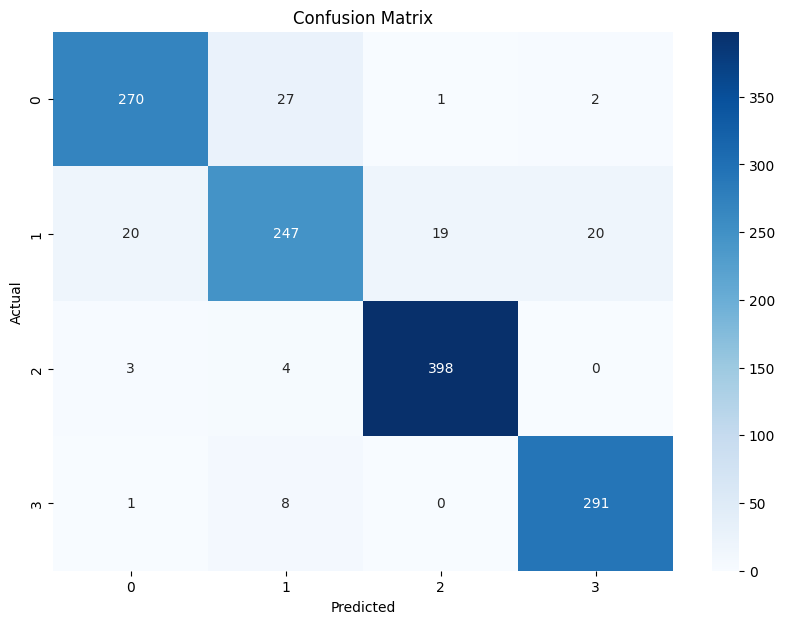

In [29]:
# Define number of epochs and early stopping patience
EPOCHS = 25
# Train the model with early stopping
results = train(
    model2,
    train_dataloader,
    test_dataloader,
    optimizer=optimizer,
    loss_fn=loss_fn,
    epochs=EPOCHS, # Include patience
    device=device
)


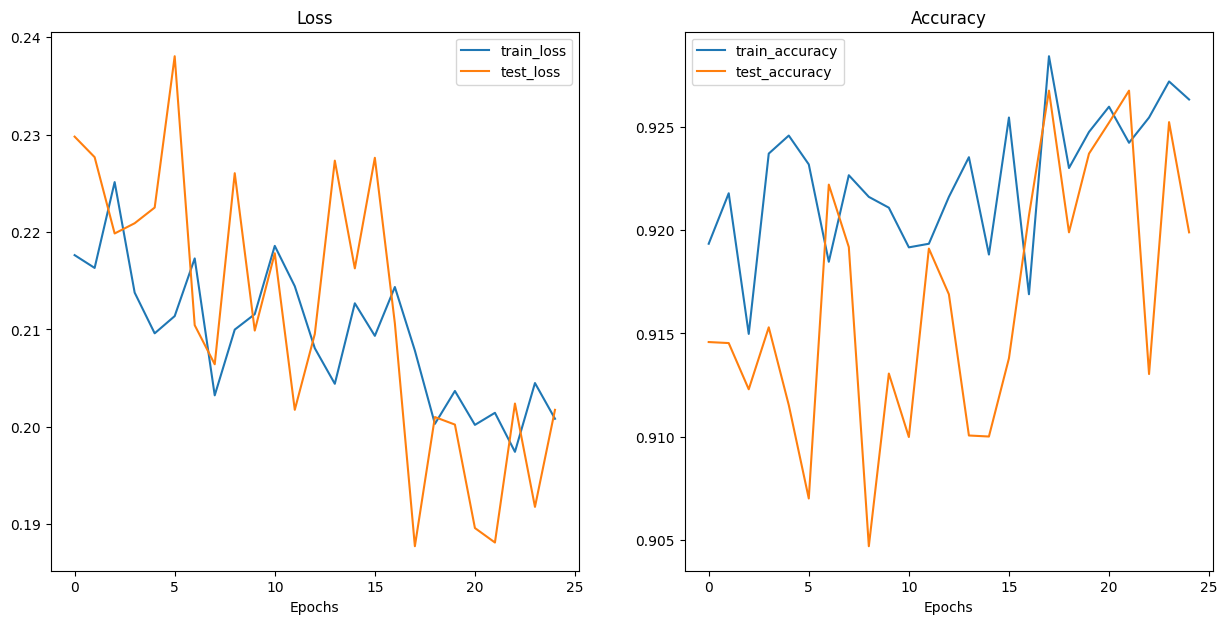

In [30]:
loss = results["train_loss"]
test_loss = results["test_loss"]

accuracy = results["train_acc"]
test_accuracy = results["test_acc"]

epochs = range(len(results["train_loss"]))

plt.figure(figsize=(15, 7))

plt.subplot(1, 2, 1)
plt.plot(epochs, loss, label="train_loss")
plt.plot(epochs, test_loss, label="test_loss")
plt.title("Loss")
plt.xlabel("Epochs")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, accuracy, label="train_accuracy")
plt.plot(epochs, test_accuracy, label="test_accuracy")
plt.title("Accuracy")
plt.xlabel("Epochs")
plt.legend()

In [32]:
save_model(model=model2,
                 target_dir="models",
                 model_name="vit-35-Epochs-92-NTP-model.pth")

[INFO] Saving model to: models/vit-35-Epochs-92-NTP-model.pth
